# Conversion Rate Challenge


## Objectif

Optimiser des taux de conversion est une des tâches les plus importantes d'un data scientist.

C'est pourquoi, nous allons construire un modèle qui va prédire le taux de conversion de clients sur un site web et faire des recommandations à notre équipe marketing pour pouvoir augmenter notre revenu.


## Description du challenge

Nous avons récolté des données à propos d'utilisateurs du site d'une entreprise _anonyme_. Votre projet est de :

1. Créer un modèle de prédiction du taux de conversion (l'utilisateur va-t-il convertir ou non?).

2. Trouver des recommandations à faire pour l'équipe Produit & Marketing afin qu'ils puissent améliorer ce taux de conversion.

## Données

Vous pourrez trouver les données dans votre dossier Projet -- CONVERSION RATE

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

!pip install s3fs

In [61]:
data=pd.read_csv("s3://full-stack-bigdata-datasets/Machine Learning Supervisé/Projet Conversion Rate/conversion_data.csv")

In [62]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [63]:
print("Number of rows: {}".format(data.shape[0]))
print("Number of columns: {}".format(data.shape[1]))
print()

print("Basics statistics: ")
data_desc = data.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*data.isnull().sum()/data.shape[0])

Number of rows: 316200
Number of columns: 6

Basics statistics: 


,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000



Percentage of missing values: 


country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64

In [64]:
data['converted'].value_counts()

0    306000
1     10200
Name: converted, dtype: int64

In [65]:
nb_visitors = data.shape[0]
nb_conversions = data['converted'].sum()
print("Number of visitors: {}".format(nb_visitors))
print("Number of conversions: {}".format(nb_conversions))
print("Conversion rate: {:.2%}".format(nb_conversions/nb_visitors))

Number of visitors: 316200
Number of conversions: 10200
Conversion rate: 3.23%


# 1- Data Viz

In [66]:
datatest = data
datatest.loc[:,'Y_N_conversion'] = datatest['converted'].apply(lambda x: 'Yes' if x==1
                                                    else 'No')
datatest.head()

,country,age,new_user,source,total_pages_visited,converted,Y_N_conversion
0,UK,25,1,Ads,1,0,No
1,US,23,1,Seo,5,0,No
2,US,28,1,Seo,4,0,No
3,China,39,1,Seo,5,0,No
4,US,30,1,Seo,6,0,No


## By country

Visitors by country


<AxesSubplot:xlabel='country', ylabel='Count'>

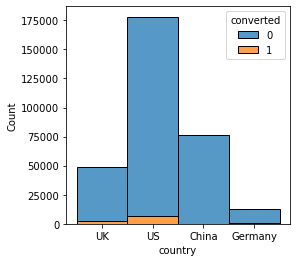

In [67]:
print("Visitors by country")
plt.figure(figsize=(4, 4))
sns.histplot(x=data["country"], hue=data["converted"], multiple="stack")

In [68]:
databycountry = data.groupby("country").mean().sort_values('converted', ascending=False)
databycountry

,age,new_user,total_pages_visited,converted
country,,,,
Germany,30.449985,0.677237,5.190717,0.062500
UK,30.451538,0.679835,5.082167,0.052632
US,30.566482,0.681985,4.930160,0.037801
China,30.672972,0.698520,4.553523,0.001332


Conversion rate by country


<AxesSubplot:xlabel='country', ylabel='converted'>

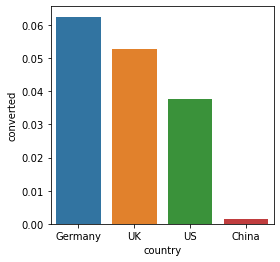

In [69]:
print("Conversion rate by country")
plt.figure(figsize=(4, 4))
sns.barplot(x=databycountry.index, y=databycountry['converted'])

## By age

Visitors by age


<AxesSubplot:xlabel='age', ylabel='Count'>

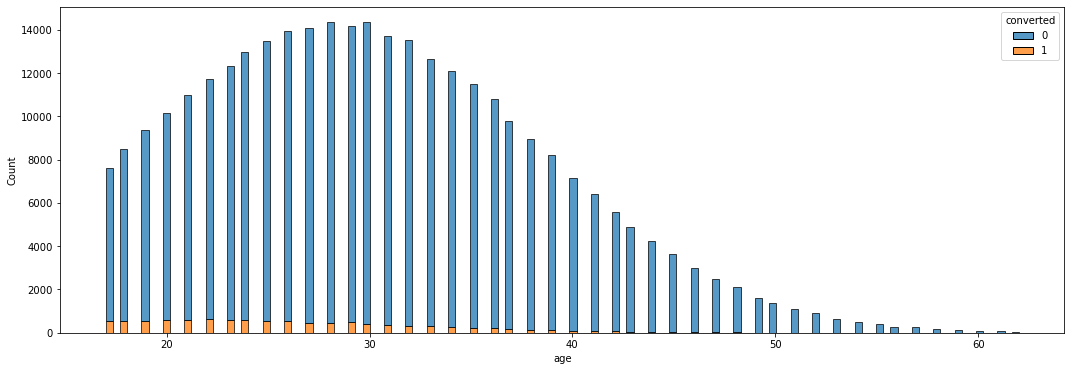

In [70]:
print("Visitors by age")
plt.figure(figsize=(18, 6))
data_filter = data[data["age"]<63]
sns.histplot(x=data_filter["age"], hue=data_filter["converted"], multiple="stack")

<Figure size 1296x432 with 0 Axes>

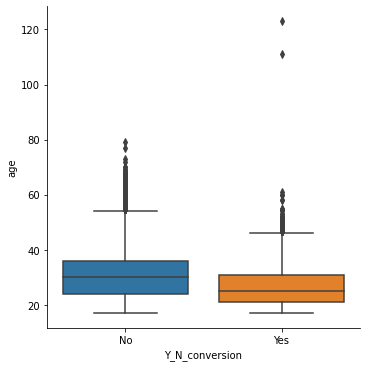

In [71]:
plt.figure(figsize=(18, 6))
sns.catplot(kind='box', data=datatest, x='Y_N_conversion', y='age')

In [72]:
databyage = data.groupby("age").mean()
databyage.head()

,new_user,total_pages_visited,converted
age,,,
17,0.667500,5.317362,0.071607
18,0.672336,5.184266,0.066029
19,0.675794,5.108996,0.058616
20,0.675266,5.129874,0.057109
21,0.679920,5.068028,0.053985


Conversion rate by age


<AxesSubplot:xlabel='age', ylabel='converted'>

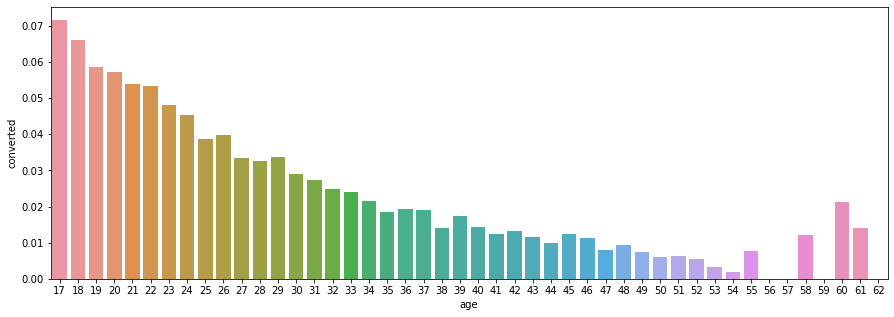

In [73]:
print("Conversion rate by age")
plt.figure(figsize=(15, 5))
databyage_filter = databyage[databyage.index<63]
sns.barplot(x=databyage_filter.index, y=databyage_filter['converted'])

## By type of user

In [74]:
databyuser = data.groupby("new_user").mean()
databyuser

,age,total_pages_visited,converted
new_user,,,
0,30.419140,5.280084,0.072002
1,30.639017,4.686155,0.014021


Conversion rate by type of user


<AxesSubplot:xlabel='new_user', ylabel='converted'>

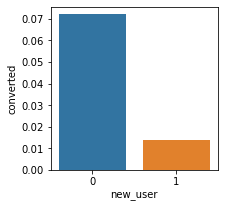

In [75]:
print("Conversion rate by type of user")
plt.figure(figsize=(3, 3))
sns.barplot(x=databyuser.index, y=databyuser['converted'])

## By source

Visitors by source


<AxesSubplot:xlabel='source', ylabel='Count'>

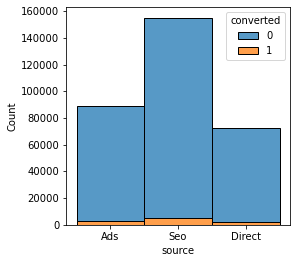

In [76]:
print("Visitors by source")
plt.figure(figsize=(4, 4))
sns.histplot(x=data["source"], hue=data["converted"], multiple="stack")

In [77]:
databysource = data.groupby("source").mean().sort_values('converted', ascending=False)
databysource

,age,new_user,total_pages_visited,converted
source,,,,
Ads,30.534742,0.685700,4.899538,0.034483
Seo,30.590835,0.684681,4.883946,0.032895
Direct,30.567978,0.686854,4.816901,0.028169


Conversion rate by source


<AxesSubplot:xlabel='source', ylabel='converted'>

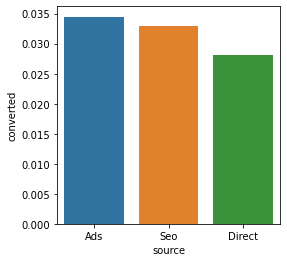

In [78]:
print("Conversion rate by source")
plt.figure(figsize=(4, 4))
sns.barplot(x=databysource.index, y=databysource['converted'])

## By visited pages

Conversion rate by number of visited pages


<AxesSubplot:xlabel='total_pages_visited', ylabel='Count'>

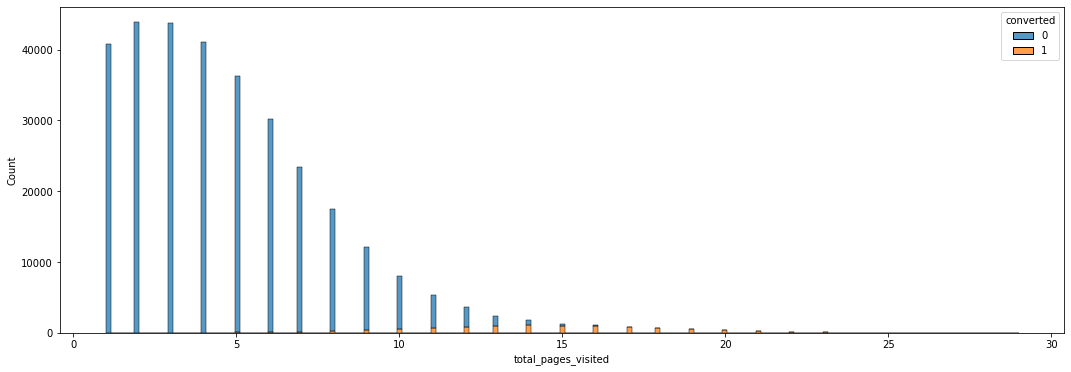

In [79]:
print("Conversion rate by number of visited pages")
plt.figure(figsize=(18, 6))
sns.histplot(x=data["total_pages_visited"], hue=data["converted"], multiple="stack")

<Figure size 1296x432 with 0 Axes>

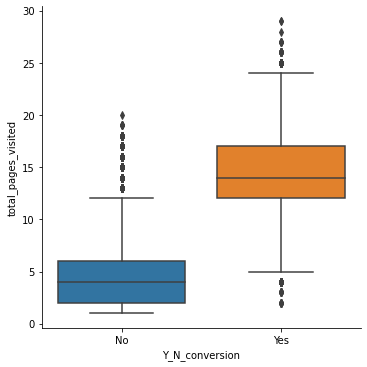

In [80]:
plt.figure(figsize=(18, 6))
sns.catplot(kind='box', data=datatest, x='Y_N_conversion', y='total_pages_visited')

In [81]:
databyvisitedpages = data.groupby("total_pages_visited").mean()
databyvisitedpages.loc[:,'visitors_nb'] = data.groupby("total_pages_visited")['converted'].count()
databyvisitedpages.loc[:,'conversions_nb'] = data.groupby("total_pages_visited")['converted'].sum()
databyvisitedpages.loc[:,'failures_nb'] = databyvisitedpages['visitors_nb']-databyvisitedpages['conversions_nb']
databyvisitedpages

,age,new_user,converted,visitors_nb,conversions_nb,failures_nb
total_pages_visited,,,,,,
1,30.711701,0.703601,0.000000,40739,0,40739
2,30.701673,0.699188,0.000228,43868,10,43858
3,30.690251,0.699035,0.000251,43829,11,43818
4,30.729572,0.696730,0.000780,41046,32,41014
5,30.629476,0.694475,0.001570,36308,57,36251
6,30.666369,0.697432,0.003437,30261,104,30157
7,30.692737,0.691587,0.006769,23488,159,23329
8,30.625214,0.692216,0.015238,17522,267,17255
9,30.604343,0.683310,0.033067,12157,402,11755


Conversion rate by number of visited pages


<AxesSubplot:xlabel='total_pages_visited', ylabel='converted'>

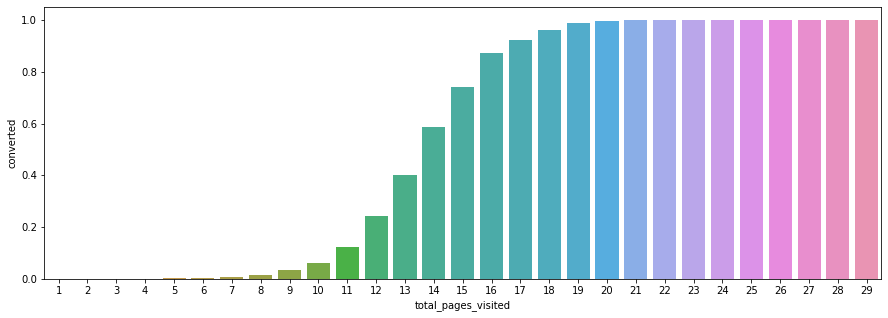

In [82]:
print("Conversion rate by number of visited pages")
plt.figure(figsize=(15, 5))
sns.barplot(x=databyvisitedpages.index, y=databyvisitedpages['converted'])

Conversion rate by number of visited pages


<AxesSubplot:xlabel='total_pages_visited', ylabel='converted'>

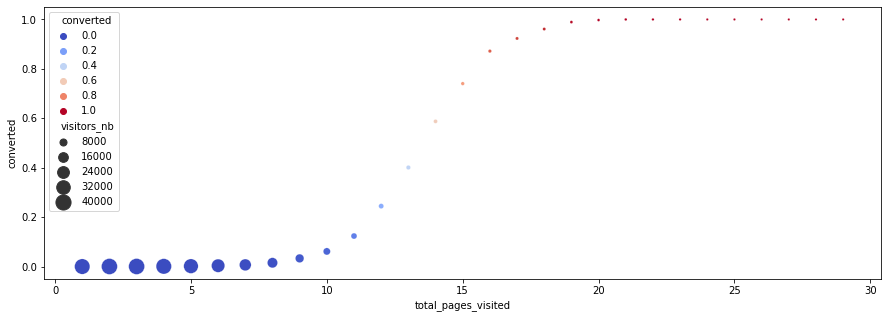

In [83]:
print("Conversion rate by number of visited pages")
plt.figure(figsize=(15, 5))
sns.scatterplot(data=databyvisitedpages, x="total_pages_visited", y="converted", size="visitors_nb", hue="converted", sizes=(5, 250), palette=sns.color_palette("coolwarm", as_cmap=True))

Correlation matrix between all numeric features


<AxesSubplot:>

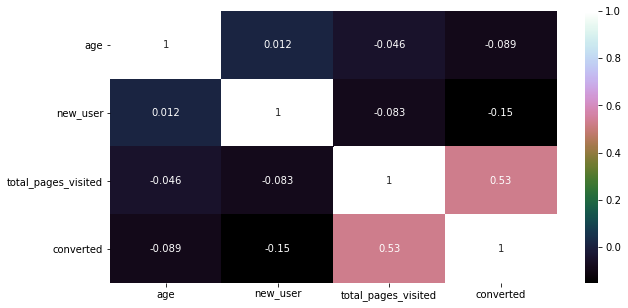

In [84]:
corr_matrix_train = data.corr()
print("Correlation matrix between all numeric features")
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix_train, annot=True, cmap = "cubehelix")

# 2- Logistic regression

## Preprocessing

In [85]:
# Separate the target variable (Y) from the explanatory variables (X)
target_name = 'converted'
print("Separating labels from features...")
Y = data.loc[:, target_name]
X = data.loc[:, ('total_pages_visited', 'new_user', 'country', 'age', 'source')]
print("...Done.")
print()
print(Y.head())
print()
print(X.head())

Separating labels from features...
...Done.

0    0
1    0
2    0
3    0
4    0
Name: converted, dtype: int64

   total_pages_visited  new_user country  age source
0                    1         1      UK   25    Ads
1                    5         1      US   23    Seo
2                    4         1      US   28    Seo
3                    5         1   China   39    Seo
4                    6         1      US   30    Seo


In [86]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X.values
Y = Y.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[1 1 'UK' 25 'Ads']
 [5 1 'US' 23 'Seo']
 [4 1 'US' 28 'Seo']
 [5 1 'China' 39 'Seo']
 [6 1 'US' 30 'Seo']]

[0, 0, 0, 0, 0]


In [87]:
# Divide dataset into train set & test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")

Dividing into train and test sets...
...Done.


In [88]:
# Create pipeline for numeric features
numeric_features = [0, 3] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [89]:
# Create pipeline for categorical features
categorical_features = [1, 2, 4] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [90]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [91]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...
[[1 1 'UK' 26 'Seo']
 [5 1 'US' 33 'Seo']
 [2 1 'US' 37 'Seo']
 [10 1 'US' 23 'Direct']
 [4 0 'China' 26 'Ads']]
...Done.
[[-1.15988055 -0.55239012  1.          0.          1.          0.
   0.          1.        ]
 [ 0.03726894  0.29450935  1.          0.          0.          1.
   0.          1.        ]
 [-0.86059317  0.7784519   1.          0.          0.          1.
   0.          1.        ]
 [ 1.53370581 -0.91534704  1.          0.          0.          1.
   1.          0.        ]
 [-0.26201843 -0.55239012  0.          0.          0.          0.
   0.          0.        ]]

Performing preprocessings on test set...
[[10 1 'US' 26 'Ads']
 [1 0 'China' 35 'Ads']
 [2 1 'US' 42 'Seo']
 [9 1 'US' 27 'Seo']
 [8 0 'US' 34 'Seo']]
...Done.
[[ 1.53370581 -0.55239012  1.          0.          0.          1.
   0.          0.        ]
 [-1.15988055  0.53648062  0.          0.          0.          0.
   0.          0.        ]
 [-0.86059317  1.383380

In [92]:
# Saving base X/Y for comparison with other models
X_base_train = X_train
X_base_test = X_test
Y_base_train = Y_train
Y_base_test = Y_test

## Model training & Predictions

In [93]:
# Train model
model = LogisticRegression()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...
...Done.


In [94]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = model.predict(X_train)
print("...Done.")
print(Y_train_pred[0:5])

Predictions on training set...
...Done.
[0 0 0 0 0]


In [95]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = model.predict(X_test)
print("...Done.")
print(Y_test_pred[0:5])

Predictions on test set...
...Done.
[0 0 0 0 0]


## Performance evaluation

In [96]:
# Print scores
print("Accuracy on train set: {:.4}".format(accuracy_score(Y_train, Y_train_pred)))
print("Accuracy on test set: {:.4}".format(accuracy_score(Y_test, Y_test_pred)))
print()
print("Recall-score on train set: {:.4}".format(recall_score(Y_train, Y_train_pred)))
print("Recall-score on test set: {:.4}".format(recall_score(Y_test, Y_test_pred)))
print()
print("Precision-score on train set: {:.4}".format(precision_score(Y_train, Y_train_pred)))
print("Precision-score on test set: {:.4}".format(precision_score(Y_test, Y_test_pred)))
print()
print("F1-score on train set: {:.4}".format(f1_score(Y_train, Y_train_pred)))
print("F1-score on test set: {:.4}".format(f1_score(Y_test, Y_test_pred)))

Accuracy on train set: 0.9861
Accuracy on test set: 0.9863

Recall-score on train set: 0.6873
Recall-score on test set: 0.6882

Precision-score on train set: 0.854
Precision-score on test set: 0.8603

F1-score on train set: 0.7616
F1-score on test set: 0.7647


<AxesSubplot:>

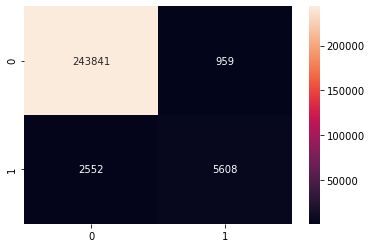

In [97]:
cm = metrics.confusion_matrix(Y_train, Y_train_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

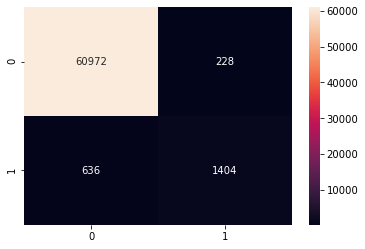

In [98]:
cm = metrics.confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True, fmt='d')

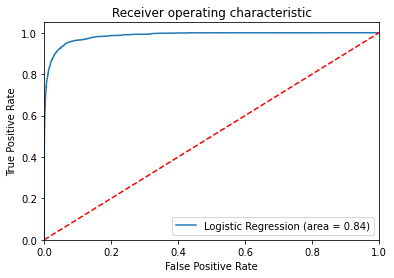

In [99]:
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## Cross Validation

In [100]:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
scores = cross_val_score(model, X_train, Y_train, cv=10)
predictions = cross_val_predict(model, X_train, Y_train, cv=10)

In [101]:
print("Predictions for each cross_validation:\n {}".format(predictions))
print("Scores for each cross_validation:\n {}".format(scores))
print("Scores mean: {:.4}".format(scores.mean()))
print("Scores std dev: {:.4}".format(scores.std()))

Predictions for each cross_validation:
 [0 0 0 ... 0 1 0]
Scores for each cross_validation:
 [0.98541271 0.98699399 0.98596616 0.98553131 0.98545225 0.9857685
 0.9858871  0.98679633 0.98640101 0.98723118]
Scores mean: 0.9861
Scores std dev: 0.0006343


In [102]:
params = {'alpha':np.arange(0,1000,10)} # determine the range of parameters to try
ridge = Ridge() # create an instance of the model
grid = GridSearchCV(ridge, params, cv=10, verbose=2)
grid_fit = grid.fit(X_train, Y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......................................... alpha=0, total=   0.2s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.2s
[CV] alpha=0 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] .......................................... alpha=0, total=   0.2s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.1s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.1s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.2s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.1s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.1s
[CV] alpha=0 .........................................................
[CV] .......................................... alpha=0, total=   0.1s
[CV] alpha=0 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.6min finished


In [104]:
print("tuned hpyerparameters :(best parameters) ",grid.best_params_)
print("accuracy :",grid.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 20}
accuracy : 0.3008246698855267


# 3- Upsampling on logistic regression

## Preprocessing

In [44]:
print(len(data[data.converted==1])*1.10)
print(len(data[data.converted==1])*1.20)
print(len(data[data.converted==1])*1.30)

11220.0
12240.0
13260.0


In [45]:
from sklearn.utils import resample

# Separate majority and minority classes
data_majority = data[data.converted==0]
data_minority = data[data.converted==1]

# Upsample minority class
data_minority_upsampled = resample(data_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=12240, # to match majority class
                                 random_state=0) # reproducible results

# Combine majority class with upsampled minority class
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

# Display new class counts
data_upsampled.converted.value_counts()

print(data_upsampled.head())
print(data_upsampled.describe())

  country  age  new_user source  total_pages_visited  converted Y_N_conversion
0      UK   25         1    Ads                    1          0             No
1      US   23         1    Seo                    5          0             No
2      US   28         1    Seo                    4          0             No
3   China   39         1    Seo                    5          0             No
4      US   30         1    Seo                    6          0             No
                 age       new_user  total_pages_visited      converted
count  318240.000000  318240.000000        318240.000000  318240.000000
mean       30.546723       0.682887             4.933908       0.038462
std         8.272549       0.465353             3.429691       0.192308
min        17.000000       0.000000             1.000000       0.000000
25%        24.000000       0.000000             2.000000       0.000000
50%        30.000000       1.000000             4.000000       0.000000
75%        36.000000  

In [46]:
# Separate the target variable (Y) from the explanatory variables (X)
target_name = 'converted'
print("Separating labels from features...")
Y = data_upsampled.loc[:, target_name]
X = data_upsampled.loc[:, ('total_pages_visited', 'new_user', 'country', 'age', 'source')]
print("...Done.")
print()
print(Y.head())
print()
print(X.head())

Separating labels from features...
...Done.

0    0
1    0
2    0
3    0
4    0
Name: converted, dtype: int64

   total_pages_visited  new_user country  age source
0                    1         1      UK   25    Ads
1                    5         1      US   23    Seo
2                    4         1      US   28    Seo
3                    5         1   China   39    Seo
4                    6         1      US   30    Seo


In [47]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X = X.values
Y = Y.tolist()
print("...Done")
print(X[0:5,:])
print()
print(Y[0:5])

Convert pandas DataFrames to numpy arrays...
...Done
[[1 1 'UK' 25 'Ads']
 [5 1 'US' 23 'Seo']
 [4 1 'US' 28 'Seo']
 [5 1 'China' 39 'Seo']
 [6 1 'US' 30 'Seo']]

[0, 0, 0, 0, 0]


In [48]:
# Divide dataset into train set & test set
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")

Dividing into train and test sets...
...Done.


In [49]:
# Create pipeline for numeric features
numeric_features = [0, 3] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

In [50]:
# Create pipeline for categorical features
categorical_features = [1, 2, 4] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [51]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [52]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test)
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...
[[5 0 'US' 26 'Seo']
 [13 0 'China' 33 'Ads']
 [6 0 'US' 19 'Ads']
 [7 1 'US' 22 'Direct']
 [2 1 'US' 22 'Direct']]
...Done.
[[ 0.01865773 -0.54968084  0.          0.          0.          1.
   0.          1.        ]
 [ 2.35186004  0.29736591  0.          0.          0.          0.
   0.          0.        ]
 [ 0.31030802 -1.39672759  0.          0.          0.          1.
   0.          0.        ]
 [ 0.60195831 -1.03370756  1.          0.          0.          1.
   1.          0.        ]
 [-0.85629314 -1.03370756  1.          0.          0.          1.
   1.          0.        ]]

Performing preprocessings on test set...
[[4 1 'US' 21 'Ads']
 [1 1 'China' 29 'Seo']
 [2 1 'China' 17 'Ads']
 [5 1 'US' 38 'Ads']
 [2 1 'US' 21 'Ads']]
...Done.
[[-0.27299256 -1.15471424  1.          0.          0.          1.
   0.          0.        ]
 [-1.14794343 -0.18666081  1.          0.          0.          0.
   0.          1.        ]
 [-0.85629314 -1.6

## Model training & Predictions

In [53]:
# Train model
model = LogisticRegression()

print("Training model...")
model.fit(X_train, Y_train)
print("...Done.")

Training model...
...Done.


In [54]:
# Predictions on **base** training set
print("Predictions on training set...")
Y_base_train_pred = model.predict(X_base_train)
print("...Done.")
print(Y_base_train_pred[0:5])

Predictions on training set...
...Done.
[0 0 0 0 0]


In [55]:
# Predictions on **base** test set
print("Predictions on test set...")
Y_base_test_pred = model.predict(X_base_test)
print("...Done.")
print(Y_base_test_pred[0:5])

Predictions on test set...
...Done.
[0 0 0 0 0]


## Performance evaluation on **base** dataset

In [56]:
# Print scores
print("Accuracy on train set: {:.4}".format(accuracy_score(Y_base_train, Y_base_train_pred)))
print("Accuracy on test set: {:.4}".format(accuracy_score(Y_base_test, Y_base_test_pred)))
print()
print("Recall-score on train set: {:.4}".format(recall_score(Y_base_train, Y_base_train_pred)))
print("Recall-score on test set: {:.4}".format(recall_score(Y_base_test, Y_base_test_pred)))
print()
print("Precision-score on train set: {:.4}".format(precision_score(Y_base_train, Y_base_train_pred)))
print("Precision-score on test set: {:.4}".format(precision_score(Y_base_test, Y_base_test_pred)))
print()
print("F1-score on train set: {:.4}".format(f1_score(Y_base_train, Y_base_train_pred)))
print("F1-score on test set: {:.4}".format(f1_score(Y_base_test, Y_base_test_pred)))

Accuracy on train set: 0.9858
Accuracy on test set: 0.9862

Recall-score on train set: 0.7311
Recall-score on test set: 0.7324

Precision-score on train set: 0.8111
Precision-score on test set: 0.8213

F1-score on train set: 0.7691
F1-score on test set: 0.7743


<AxesSubplot:>

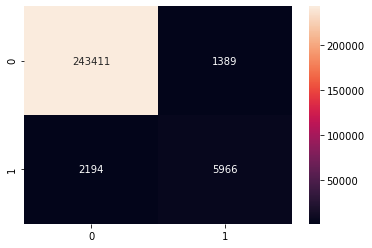

In [57]:
cm = metrics.confusion_matrix(Y_base_train, Y_base_train_pred)
sns.heatmap(cm, annot=True, fmt='d')

<AxesSubplot:>

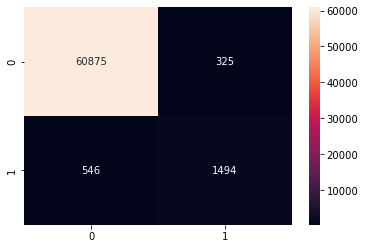

In [58]:
cm = metrics.confusion_matrix(Y_base_test, Y_base_test_pred)
sns.heatmap(cm, annot=True, fmt='d')